# **Práctica 2:** Deep Learning para Clasificación

## Sistemas Inteligentes para la Gestión en la Empresa

**Autor**: Pablo Valenzuela Álvarez (pvalenzuela@correo.ugr.es)

In [59]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from collections import Counter

# Definimos el dispositivo (GPU o CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(device)

random_seed = 12345
torch.manual_seed(random_seed)

### Carga de datos

In [60]:
# from google.colab import drive
# drive.mount('/content/drive')
# PATH = "/content/drive/MyDrive/Colab Notebooks/pr2-starting-package/starting-package"

PATH = "G:\Mi unidad\Colab Notebooks\pr2-starting-package\starting-package"

DATA_x20 = PATH + "/data x20"
DATA_x200 = PATH + "/data x200"

### Exploración de datos

In [61]:
dimensions = ImageFolder(DATA_x20)
# shapes = [(img.height, img.width) for img, _ in dimensions]
# heights, widths = [[h for h,_ in shapes], [w for _,w in shapes]]
# median_height = int(np.median(heights))
# median_width = int(np.median(widths))
median_height = 375 # son los resultados que salen de ejecutar las lineas de arriba
median_width = 500
print(f"Tamaño medio de las imagenes [height: {median_height}, width: {median_width}]")

Tamaño medio de las imagenes [height: 375, width: 500]


In [62]:
exp_transforms = transforms.Compose([         
    transforms.Resize((256,256)),          
    transforms.ToTensor()
])

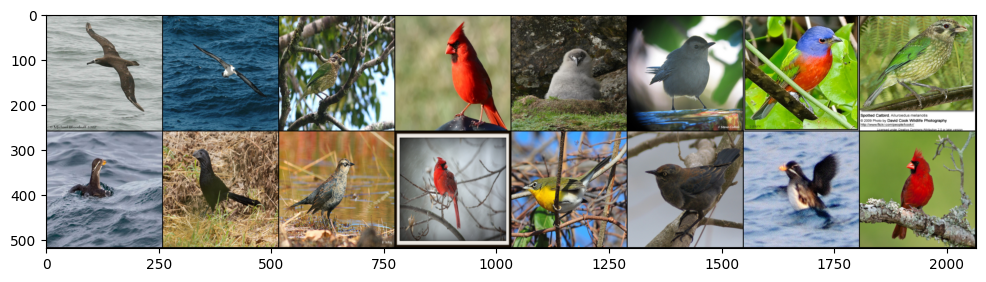

001.Black_footed_Albatross 002.Laysan_Albatross 018.Spotted_Catbird 017.Cardinal 003.Sooty_Albatross 019.Gray_Catbird 016.Painted_Bunting 018.Spotted_Catbird 008.Rhinoceros_Auklet 004.Groove_billed_Ani 011.Rusty_Blackbird 017.Cardinal 020.Yellow_breasted_Chat 011.Rusty_Blackbird 008.Rhinoceros_Auklet 017.Cardinal


In [63]:
dataset = ImageFolder(root=DATA_x20, transform=exp_transforms)
classes = dataset.classes

mini_batch=16
sample = DataLoader(dataset, batch_size=mini_batch, shuffle=True)

def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(12, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(sample)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(mini_batch)))

C:\Users\pvale\AppData\Local\Temp\ipykernel_14332\1914815783.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(class_names)).colors


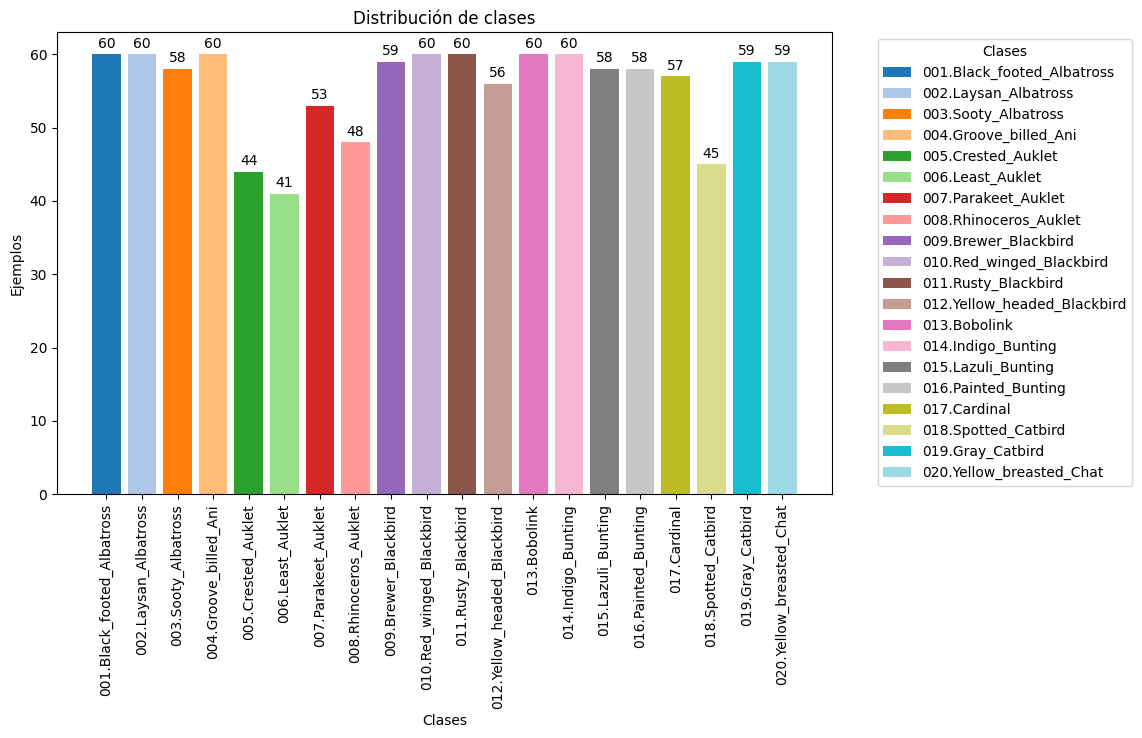

In [64]:
class_counts = Counter(dataset.targets)

class_names = [classes[i] for i in class_counts.keys()]
counts = [class_counts[i] for i in class_counts.keys()]

colors = plt.cm.get_cmap('tab20', len(class_names)).colors 

plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, counts, color=colors)
plt.xlabel('Clases')
plt.ylabel('Ejemplos')
plt.title('Distribución de clases')
plt.xticks(rotation=90)  


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.legend(bars, class_names, title="Clases", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

### Particionamiento de datos

In [65]:
# valores de normalizacion
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# transformaciones para entrenar
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats)
])

# transformaciones para validar
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats)
])

In [66]:
# Cargamos el conjunto de datos
full_dataset = ImageFolder(root=DATA_x20)

# Dividimos los conjuntos
split = 0.8  # 80/20
train_size = int(split * len(full_dataset))
test_size = len(full_dataset) - train_size
trainset, testset = random_split(full_dataset, [train_size, test_size])

print(f"Tamaño del conjunto de entreno: {train_size}")
print(f"Tamaño del conjunto de validación: {test_size}")

# Aplicamos las transformaciones
trainset.dataset.transform = train_transforms
testset.dataset.transform = test_transforms

# Creamos los DataLoaders
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

Tamaño del conjunto de entreno: 892
Tamaño del conjunto de validación: 223


### Clasificación

In [67]:
class BirdCNN(nn.Module):
    def __init__(self):
        super(BirdCNN, self).__init__()
        
        # Capas convolucionales
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        # Capa de pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Capas totalmente conectadas
        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc3 = nn.Linear(512, len(classes))
        
        # Capa dropout
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)        
        x = self.fc3(x)
        return x

model = BirdCNN()

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [69]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    
    metrics = {"loss": [], "accuracy": []}
            
    for epoch in range(num_epochs):
        
        ### Entrenamiento ###
        
        running_loss = 0.0
        model.train()  
        
        tqdm_train = tqdm(enumerate(train_loader), total=len(train_loader))  

        for i, data in tqdm_train:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # movemos a la GPU, si esta disponible
            optimizer.zero_grad()               # resetea los gradientes
            outputs = model(inputs)             # calcula las salidas para las entradas del lote
            loss = criterion(outputs, labels)   # calcula las perdidas
            loss.backward()                     # calcula los gradientes con las perdidas
            optimizer.step()                    # actualiza los parametros del modelo
            running_loss += loss.item()
            tqdm_train.set_description(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / (i + 1):.3f}')

        
        ### Validación ### 
        
        model.eval()  
        val_loss = 0.0
        correct = 0
        total = 0
        
        tqdm_val = tqdm(enumerate(test_loader), total=len(test_loader))  

        with torch.no_grad():           # funcionamiento similar al entreno
            for j, data in tqdm_val:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)           # obtiene las predicciones del modelo
                total += labels.size(0)
                correct += (predicted == labels).sum().item()       # predicciones correctas

                tqdm_val.set_description(f'  --> Epoch {epoch + 1} accuracy: {(100 * correct / total):.2f}%')
                
        metrics["loss"].append(np.round(running_loss/len(train_loader),4))     
        metrics["accuracy"].append(np.round((100 * correct / total),4))
        
    return metrics

In [70]:
model.to(device)
metrics = train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=20)

  --> Epoch 20 accuracy: 36.77%: 100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


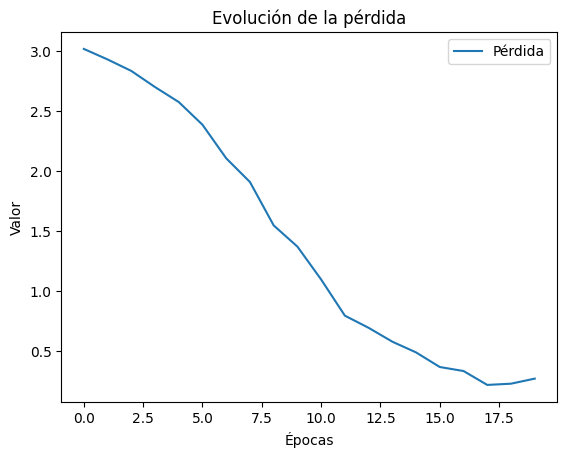

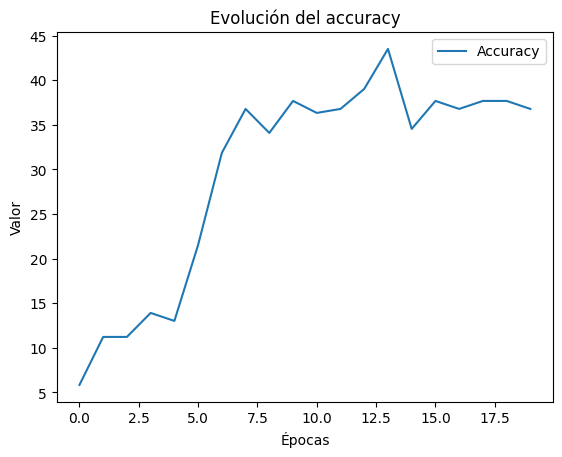

In [71]:
df_metrics = pd.DataFrame(metrics)

df_loss = df_metrics[["loss"]].plot()
plt.xlabel('Épocas')
plt.ylabel('Valor')
plt.title('Evolución de la pérdida')
plt.legend(['Pérdida'])
plt.show()

df_acc = df_metrics[["accuracy"]].plot()
plt.xlabel('Épocas')
plt.ylabel('Valor')
plt.title('Evolución del accuracy')
plt.legend(['Accuracy'])
plt.show()

In [72]:
# Guarda el modelo
torch.save(model.state_dict(), 'models/model_x20.pth')

### TEST

In [73]:
# Carga del modelo
test_model = BirdCNN()
test_model.load_state_dict(torch.load('models/model_x20.pth'))

<All keys matched successfully>

In [74]:
# Función para evaluar el modelo
def evaluate_model(model, test_loader):
    model.eval()
    correct_global = 0
    total_global = 0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_global += labels.size(0)
            correct_global += (predicted == labels).sum().item()
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    print(f'Accuracy: {np.round((100 * correct_global / total_global),2)}%')

    # for classname, correct_count in correct_pred.items():
    #     accuracy = 100 * float(correct_count) / total_pred[classname]
        # print(f'Accuracy de: {classname:5s} --> {accuracy:.2f}%')
        
    plot_class_accuracy(correct_pred, total_pred)

def plot_class_accuracy(correct_pred, total_pred):
    classes = list(correct_pred.keys())
    accuracy = [(correct_pred[classname] / total_pred[classname]) * 100 for classname in classes]
    
    
    colors = plt.cm.get_cmap('tab20', len(class_names)).colors 

    plt.figure(figsize=(10, 5))
    bars = plt.bar(classes, accuracy, color=colors)

    for bar, acc in zip(bars, accuracy):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 1, f'{acc:.2f}%', ha='center', color='black')

    plt.xlabel('Clases')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy por clase')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Accuracy: 36.77%


C:\Users\pvale\AppData\Local\Temp\ipykernel_14332\2965979614.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(class_names)).colors


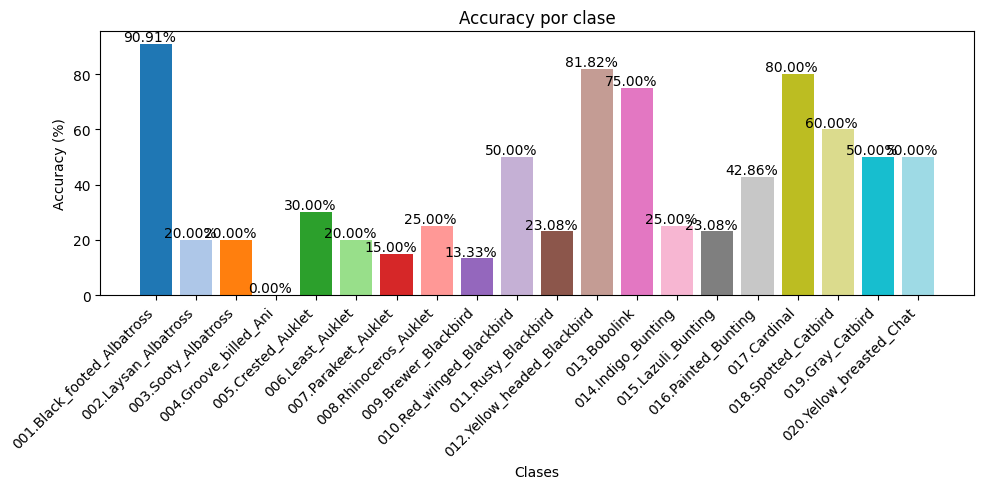

In [75]:
# Evaluar el modelo
evaluate_model(test_model, testloader)